In [6]:
import math, re, os, warnings
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image_dataset_from_directory

import time

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Specify file paths

train_data_file_path = 'MRI Dataset/Data/train.parquet'
test_data_file_path = 'MRI Dataset/Data/test.parquet'

# Read data in

train_data = pd.read_parquet(train_data_file_path)
test_data = pd.read_parquet(test_data_file_path)

In [8]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        return img

In [9]:
train_data['image'] = train_data['image'].apply(dict_to_image)
test_data['image'] = test_data['image'].apply(dict_to_image)

In [10]:
train_data.head()

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


In [11]:
X = train_data['image']
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.75, random_state=10)

In [12]:
X_test = test_data['image']
y_test = test_data['label']

In [13]:
# Training data

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_df = pd.concat([X_train_df, y_train_df], axis=1)

# Validation data

X_val_df = pd.DataFrame(X_val)
y_val_df = pd.DataFrame(y_val)
val_df = pd.concat([X_val_df, y_val_df], axis=1)

In [14]:
# Test data

X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

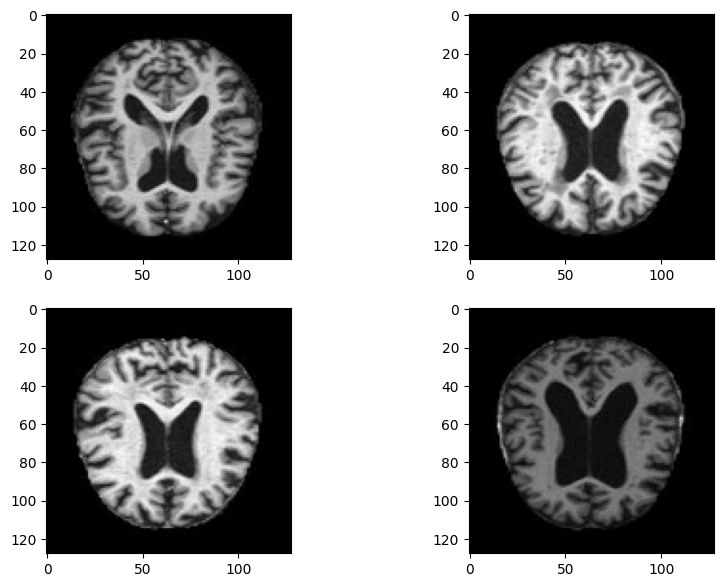

In [15]:
# Explore some images

# Training images
mri_images = train_df['image']

fig = plt.figure(figsize=(10, 7)) 

for i in range(0, len(mri_images), 1000):
    n = int((i / 1000) + 1)
    
    fig.add_subplot(2,2,n)
    plt.imshow(mri_images.iloc[i])

plt.show()

In [16]:
labels = train_data['label']
label_counts = pd.DataFrame(labels.value_counts())
label_counts.index = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
label_counts

,count
Non Demented,2566
Very Mild Demented,1781
Mild Demented,724
Moderate Demented,49


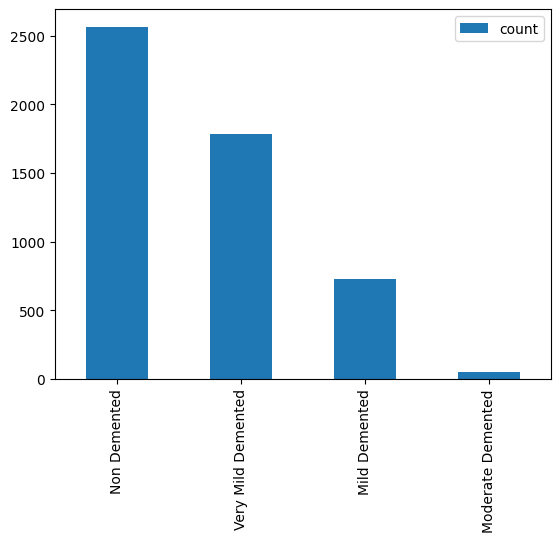

In [17]:
label_plot = label_counts.plot.bar()
plt.show()

In [18]:
# Preprocess data

from tensorflow.keras.utils import to_categorical

# Define reshape function
def reshape_X_y(X, y):
    X_array = []
    for x in X:
        X_array.append(x)
    
    y = to_categorical(y)

    # Normalisation
    X_array = np.array(X_array)
    X_array = X_array / 255.0
    
    y = np.array(y)
    
    print(X_array.shape, y.shape)
    return X_array, y

# Training data
X_train_ds, y_train_ds = reshape_X_y(X_train, y_train)

# Validation data
X_val_ds, y_val_ds = reshape_X_y(X_val, y_val)

# Test data
X_test_ds, y_test_ds = reshape_X_y(X_test, y_test)

(3840, 128, 128, 3) (3840, 4)
(1280, 128, 128, 3) (1280, 4)
(1280, 128, 128, 3) (1280, 4)


In [19]:
class_names = np.array(['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'])
print(class_names)

['Non Demented' 'Very Mild Demented' 'Mild Demented' 'Moderate Demented']


In [20]:
# Model building

In [21]:
# Model 1: Custom convolutional net

model1 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Second Block
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
start = time.time()

history1 = model1.fit(X_train_ds, y_train_ds,
                      steps_per_epoch=len(X_train_ds),
                      batch_size=32,
                      validation_data=(X_val_ds, y_val_ds),
                      validation_steps=len(X_val_ds),
                      epochs=40
)

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.4906 - loss: 1.0278 - val_accuracy: 0.5320 - val_loss: 0.9792
Epoch 2/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5254 - loss: 0.9746 - val_accuracy: 0.5398 - val_loss: 0.9159
Epoch 3/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5577 - loss: 0.9218 - val_accuracy: 0.5852 - val_loss: 0.8859
Epoch 4/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5889 - loss: 0.8709 - val_accuracy: 0.6195 - val_loss: 0.8537
Epoch 5/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6245 - loss: 0.7964 - val_accuracy: 0.6172 - val_loss: 0.7944
Epoch 6/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6939 - loss: 0.6879 - val_accuracy: 0.6938 - val_loss: 0.6784
Epoch 7/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7646 - loss: 0.5615 - val_accuracy: 0.6906 - val_loss: 0.6859
Epoch 8/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8278 - loss: 0.4456 - 

In [23]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,642,062 (48.23 MB)

 Trainable params: 4,214,020 (16.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,428,042 (32.15 MB)

In [24]:
history1_plot = pd.DataFrame(history1.history)
history1_plot.head()

,accuracy,loss,val_accuracy,val_loss
0,0.491146,1.026639,0.532031,0.979173
1,0.525521,0.974314,0.539844,0.915897
2,0.557292,0.922176,0.585156,0.885896
3,0.589063,0.870608,0.619531,0.853710
4,0.624740,0.795980,0.617188,0.794430
